# Computer Science Group 3

Members:
1.	Arya Pradeep Menon (K2275592)
2.	Gudikota Dharani Kumar Gupta (K2203537)
3.	Alan Jose Tom (K2211586)
4.	Alan Vinodh (K2172630)


# Import Libraries

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import np_utils
from keras.applications import VGG16
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model

# Load Data

In [ ]:
# Define data path and image dimensions
data_path = np.load('/content/drive/MyDrive/Colab Notebooks/breastmnist.npz')


In [ ]:
img_width, img_height = 50, 50
with data_path as data:
  x_train = data['train_images']
  y_train = data['train_labels']
  x_val = data['val_images']
  y_val = data['val_labels']
  x_test = data['test_images']
  y_test = data['test_labels']

In [ ]:
# Verify no records are missing
assert not np.any(np.isnan(x_train))
assert not np.any(np.isnan(y_train))
assert not np.any(np.isnan(x_test))
assert not np.any(np.isnan(y_test))

# Plot Sample

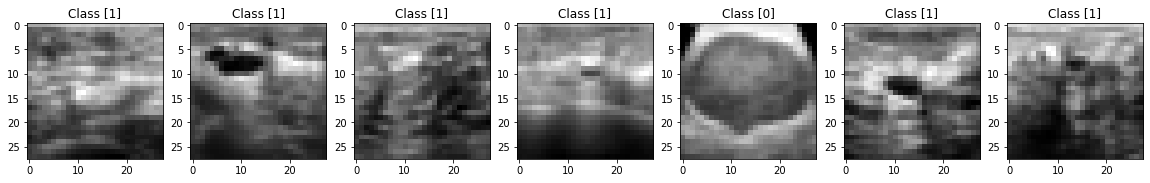

In [ ]:
fig, ax = plt.subplots(1, 7, figsize=(20, 5))
for i in range(7):
    ax[i].imshow(x_train[i], interpolation = 'none', cmap = 'gray')
    ax[i].set_title('Class {}'.format(y_train[i]))
plt.show()

In [ ]:
# Printing number of samples in each class

counts = np.bincount(y_train[:, 0])
print(counts)

# Calculating weights for dealing class imbalance problem

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

class_weight = {0: weight_for_0, 1: weight_for_1}

[147 399]


# Data Preprocessing

In [ ]:
x_train = x_train.reshape(546, 28, 28, 1)
x_val = x_val.reshape(78, 28, 28, 1)
x_test = x_test.reshape(156, 28, 28, 1)

# Converting to 3 channels

x_new=np.zeros((546,28,28,3))
for i in range(0,546):
  for j in range(28):
    for k in range(28):
      x_new[i][j][k][0] = x_train[i][j][k][0]
      x_new[i][j][k][1] = x_train[i][j][k][0]
      x_new[i][j][k][2] = x_train[i][j][k][0]

x_newval=np.zeros((78,28,28,3))
for i in range(0,78):
  for j in range(28):
    for k in range(28):
      x_newval[i][j][k][0] = x_val[i][j][k][0]
      x_newval[i][j][k][1] = x_val[i][j][k][0]
      x_newval[i][j][k][2] = x_val[i][j][k][0]
x_newtest=np.zeros((156,28,28,3))
for i in range(0,156):
  for j in range(28):
    for k in range(28):
      x_newtest[i][j][k][0] = x_test[i][j][k][0]
      x_newtest[i][j][k][1] = x_test[i][j][k][0]
      x_newtest[i][j][k][2] = x_test[i][j][k][0]
      
x_train = tf.image.resize(x_new, (50, 50)) / 255.0
x_val = tf.image.resize(x_newval, (50, 50)) / 255.0
x_test = tf.image.resize(x_newtest, (50, 50)) / 255.0
print("X_Train shape", x_train.shape)
print("X_Validation shape", x_val.shape)
print("X_Test shape", x_test.shape)

X_Train shape (546, 50, 50, 3)
X_Validation shape (78, 50, 50, 3)
X_Test shape (156, 50, 50, 3)


In [ ]:
# One-hot Encoder
y_train = np_utils.to_categorical(y_train)
y_val = np_utils.to_categorical(y_val)
y_test = np_utils.to_categorical(y_test)

# Build Model

In [ ]:
# Define the VGG-16 model

model = VGG16(weights='imagenet', include_top=False, input_shape=(50, 50, 3))

# Freeze the pre-trained layers
for layer in model.layers:
    layer.trainable = False

# Add custom layers for classification
x = model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
model_final = Model(inputs=model.input, outputs=predictions)

model_final.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [ ]:
# Compile the model

model_final.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Defining callback to avaoid overfitting

callbacks = [EarlyStopping(monitor="val_loss", patience=3),
ModelCheckpoint(filepath="/content/drive/MyDrive/Colab Notebooks/Models/Breast_VGG/best_model.h5",
monitor="val_loss",
save_best_only=True)]

In [ ]:
# Train the model

history = model_final.fit(x_train,y_train, epochs=50, callbacks = callbacks, validation_data=(x_val,y_val))

Epoch 1/50
18/18 [==============================] - 24s 1s/step - loss: 0.6354 - accuracy: 0.7088 - val_loss: 0.5023 - val_accuracy: 0.7436
Epoch 2/50
18/18 [==============================] - 18s 1s/step - loss: 0.5263 - accuracy: 0.7637 - val_loss: 0.4656 - val_accuracy: 0.8333
Epoch 3/50
18/18 [==============================] - 17s 957ms/step - loss: 0.5021 - accuracy: 0.7656 - val_loss: 0.4426 - val_accuracy: 0.8333
Epoch 4/50
18/18 [==============================] - 17s 957ms/step - loss: 0.4829 - accuracy: 0.7930 - val_loss: 0.4783 - val_accuracy: 0.8077
Epoch 5/50
18/18 [==============================] - 18s 994ms/step - loss: 0.4421 - accuracy: 0.8077 - val_loss: 0.4208 - val_accuracy: 0.8333
Epoch 6/50
18/18 [==============================] - 18s 986ms/step - loss: 0.4571 - accuracy: 0.8004 - val_loss: 0.4067 - val_accuracy: 0.8462
Epoch 7/50
18/18 [==============================] - 18s 1s/step - loss: 0.4346 - accuracy: 0.8095 - val_loss: 0.4019 - val_accuracy: 0.8333
Epoch 8/

# Model Evaluation

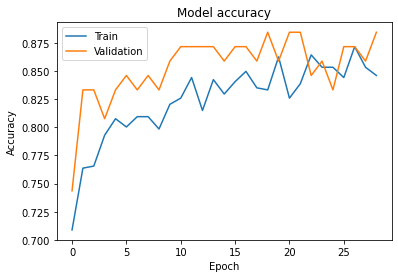

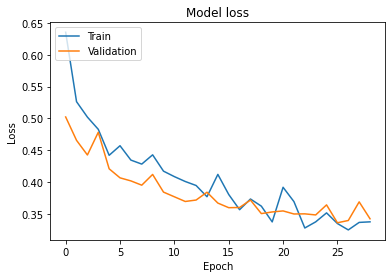

In [ ]:
# Plot the accuracy and loss curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model_final = load_model("/content/drive/MyDrive/Colab Notebooks/Models/Breast_VGG/best_model.h5")
model_final.save("/content/drive/MyDrive/Colab Notebooks/Models/Breast_VGG/breastVGG_1.h5")

In [ ]:
# Model evaluation based on validation set
score = model_final.evaluate(x_val, y_val, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.33608555793762207
Test accuracy: 0.8717948794364929


In [ ]:
# Making predictions on test set

y_pred = np.argmax(model_final.predict(x_test), axis=-1)
y_test = np.argmax(y_test, axis=-1)

5/5 [==============================] - 6s 1s/step


In [ ]:
# Metrics Evaluation

print(classification_report(y_test, y_pred))

print("\nConfusion Matrix\n")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.67      0.76        42
           1       0.89      0.96      0.92       114

    accuracy                           0.88       156
   macro avg       0.88      0.82      0.84       156
weighted avg       0.88      0.88      0.88       156


Confusion Matrix

[[ 28  14]
 [  4 110]]


# Dealing Class Imbalance

In [ ]:
history = model_final.fit(x_train,y_train, epochs=50, class_weight = class_weight, callbacks = callbacks, validation_data=(x_val,y_val))

Epoch 1/50
18/18 [==============================] - 18s 951ms/step - loss: 0.0016 - accuracy: 0.8462 - val_loss: 0.3700 - val_accuracy: 0.8333
Epoch 2/50
18/18 [==============================] - 16s 894ms/step - loss: 0.0016 - accuracy: 0.8297 - val_loss: 0.3839 - val_accuracy: 0.8462
Epoch 3/50
18/18 [==============================] - 16s 925ms/step - loss: 0.0016 - accuracy: 0.8223 - val_loss: 0.3877 - val_accuracy: 0.8333
Epoch 4/50
18/18 [==============================] - 19s 1s/step - loss: 0.0017 - accuracy: 0.8168 - val_loss: 0.3895 - val_accuracy: 0.8333


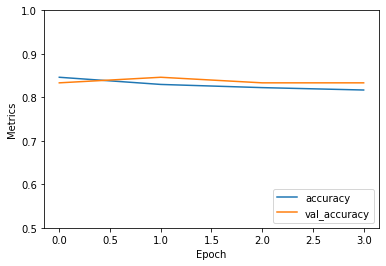

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [ ]:
model_final = load_model("/content/drive/MyDrive/Colab Notebooks/Models/Breast_VGG/best_model.h5")

# Image Augmentation

In [ ]:
augmentation = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)
augmentation.fit(x_train)

In [ ]:
history = model_final.fit(augmentation.flow(x_train, y_train, batch_size=32, seed = 42), epochs=50, class_weight = class_weight, callbacks = callbacks, validation_data=(x_val,y_val))

Epoch 1/50
18/18 [==============================] - 18s 983ms/step - loss: 0.0039 - accuracy: 0.7711 - val_loss: 0.3868 - val_accuracy: 0.8462
Epoch 2/50
18/18 [==============================] - 20s 1s/step - loss: 0.0033 - accuracy: 0.7234 - val_loss: 0.4465 - val_accuracy: 0.7949
Epoch 3/50
18/18 [==============================] - 17s 966ms/step - loss: 0.0031 - accuracy: 0.7179 - val_loss: 0.4199 - val_accuracy: 0.8205
Epoch 4/50
18/18 [==============================] - 17s 962ms/step - loss: 0.0029 - accuracy: 0.7216 - val_loss: 0.4692 - val_accuracy: 0.7821


# Reference

Cassimiro, G. (2021) Transfer Learning with VGG16 and Keras. Available at: https://towardsdatascience.com/transfer-learning-with-vgg16-and-keras-50ea161580b4 (Accessed: Mar 14, 2023).
